Канунникова Юлия МОАД 1 курс

In [1]:
import pandas as pd
import re
from sklearn.utils import resample
from pandarallel import pandarallel

In [2]:
df = pd.read_csv('dataset_hw1.csv', sep=";", engine="python")

In [3]:
# проверяем, есть ли дубликаты и удаляем их, если они есть
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)

In [4]:
# минимальный класс
df["Score"].value_counts()
print(df["Score"].value_counts().to_string())

Score
5    16969
4     3710
1     2448
3     1991
2     1409


In [5]:
min_class_size = df["Score"].value_counts().min()
df_balanced = df.groupby("Score", group_keys=False).apply(
    lambda x: resample(x, n_samples=min_class_size, random_state=42)
).reset_index(drop=True)

/var/folders/g4/2d81vhys351_27jy9jgzdy340000gn/T/ipykernel_45743/1427650489.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("Score", group_keys=False).apply(


In [6]:
df_balanced["Score"].value_counts()
print(df_balanced["Score"].value_counts().to_string())

Score
1    1409
2    1409
3    1409
4    1409
5    1409


In [7]:
import string
from nltk.corpus import stopwords
import nltk

# загружаем стоп-слова
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# инициализируем pandarallel
pandarallel.initialize(progress_bar=True)

# функция очистки текста с дополнительными фильтрами
def clean_text(text):
    text = text.lower()  # приводим к нижнему регистру
    text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE)  # удаляем html-теги <br>
    text = re.sub(r'http\S+', '', text)  # удаляем ссылки
    text = re.sub(r'["?/|<>&;:\=%!@#__$1234567890#—ツ►๑۩۞۩•*”˜˜”)*°(°*`,.-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()  # убираем лишние пробелы

    # удаляем стоп-слова
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# выполняем распараллеленный препроцессинг текста
df["Cleaned_Text"] = df["Text"].parallel_apply(clean_text)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirralz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("TF-IDF векторизация запущена...")

# инициализируем TF-IDF векторизатор
vectorizer = TfidfVectorizer()

# обучаем TF-IDF на очищенных текстах
tfidf_matrix = vectorizer.fit_transform(df["Cleaned_Text"])

# получаем количество токенов
max_tokens = len(vectorizer.get_feature_names_out())

print(f"Количество документов: {tfidf_matrix.shape[0]}")
print(f"Максимальное количество токенов (TF-IDF): {max_tokens}")

TF-IDF векторизация запущена...
Количество документов: 26527
Максимальное количество токенов (TF-IDF): 39739


In [9]:
from bpemb import BPEmb
import pickle
# список размеров словаря (количество токенов), на которых будем обучать токенизатор
vocab_sizes = [1000, 5000, 10000, 20000, max_tokens]

# обучаем и сохраняем токенизаторы для каждого vocab_size
for vocab_size in vocab_sizes:
    print(f"Обучение BPEmb на {vocab_size} токенах...")

    # создаем и обучаем BPEmb
    tokenizer = BPEmb(lang="en", vs=vocab_size)

    # сохраняем обученный токенизатор
    model_filename = f"bpemb_tokenizer_{vocab_size}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(tokenizer, f)

    print(f"Токенизатор сохранён в {model_filename}")

print("Обучение завершено.")

Обучение BPEmb на 1000 токенах...
Токенизатор сохранён в bpemb_tokenizer_1000.pkl
Обучение BPEmb на 5000 токенах...
Токенизатор сохранён в bpemb_tokenizer_5000.pkl
Обучение BPEmb на 10000 токенах...
Токенизатор сохранён в bpemb_tokenizer_10000.pkl
Обучение BPEmb на 20000 токенах...
BPEmb fallback: en from vocab size 20000 to 200000
Токенизатор сохранён в bpemb_tokenizer_20000.pkl
Обучение BPEmb на 39739 токенах...
BPEmb fallback: en from vocab size 39739 to 200000
Токенизатор сохранён в bpemb_tokenizer_39739.pkl
Обучение завершено.


Testing BPEmb with 1000 tokens...

GaussianNB()
              precision    recall  f1-score   support

           1       0.14      0.06      0.08       472
           2       0.06      0.73      0.11       269
           3       0.08      0.28      0.12       365
           4       0.11      0.03      0.04       763
           5       0.76      0.02      0.04      3437

    accuracy                           0.08      5306
   macro avg       0.23      0.22      0.08      5306
weighted avg       0.53      0.08      0.05      5306

-------------------------------------
Confusion matrix:
[[  28  337   97    6    4]
 [  10  196   54    4    5]
 [  14  234  104   10    3]
 [  27  514  193   20    9]
 [ 124 2174  935  139   65]]

Time of execution (sec): 0.1004

Testing BPEmb with 5000 tokens...

GaussianNB()
              precision    recall  f1-score   support

           1       0.11      0.11      0.11       472
           2       0.05      0.61      0.10       269
           3       0.

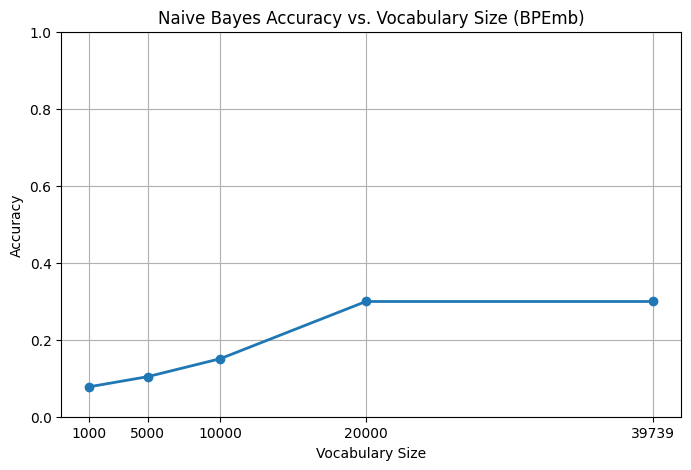

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
import time
import matplotlib.pyplot as plt

# list of vocab sizes
vocab_sizes = [1000, 5000, 10000, 20000, 39739]
accuracies = []  # список для хранения точности

for vocab_size in vocab_sizes:
    print(f"Testing BPEmb with {vocab_size} tokens...\n")

    # load pre-trained tokenizer
    model_filename = f"bpemb_tokenizer_{vocab_size}.pkl"
    with open(model_filename, "rb") as f:
        tokenizer = pickle.load(f)

    # tokenize cleaned text
    df["Tokenized_Text"] = df["Cleaned_Text"].apply(lambda x: " ".join(tokenizer.encode(x)))

    # create TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df["Tokenized_Text"])

    # target variable (classes)
    y = df["Score"]

    # split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42)

    # define model
    model = GaussianNB()

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # make predictions
    y_pred = model.predict(X_test)

    # evaluate model
    print(model)  # print model details
    print(metrics.classification_report(y_test, y_pred))
    print("-------------------------------------")
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(f"\nTime of execution (sec): {train_time:.4f}\n")
    print("=" * 80)  # separator for readability

    # store accuracy for plotting
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print("Testing completed.")

# plot accuracy vs vocabulary size
plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, accuracies, marker="o", linestyle="-", linewidth=2)

# график подписей
plt.xlabel("Vocabulary Size")
plt.ylabel("Accuracy")
plt.title("Naive Bayes Accuracy vs. Vocabulary Size (BPEmb)")
plt.grid(True)
plt.xticks(vocab_sizes)
plt.ylim(0, 1)  # ограничиваем точность от 0 до 100%

# показываем график
plt.show()